In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import itertools
from sklearn import preprocessing
import itertools
import pickle

%matplotlib inline

# %% load metadata
metadata = pd.read_pickle('/home/frati/Grasping/Squared/metadata.pkl.compress', compression='gzip')

# Dataset Overview

In [2]:
# Counter can't work with lists so we stringify them
def stringify(x):
    return ' '.join(x)

1631


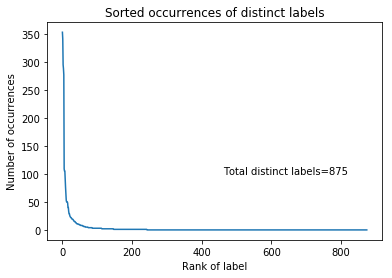

In [3]:
labels = metadata#['labels']
labels = labels[labels['hot'] == False] # exclude hot
labels = labels[labels['impaired'] == False] # exclude impaired
labels = labels[labels['failed'] == False] # exclude failed
labels.index = list(range(len(labels)))
print(len(labels))
labels = metadata['labels']

tags = [item for sublist in metadata['labels'] for item in sublist]

# turn into strings to compare them
str_labels = labels.apply(stringify)

# use counter to compute frquencies
count = Counter(str_labels)
#count.most_common(10)
# separate labels and occurrences
labels, label_occurrences = zip(*count.most_common())
# %% plot occurreces
num_occurrences_label = len(label_occurrences)
label_indexes = np.arange(num_occurrences_label)
plt.plot(label_indexes, label_occurrences)
plt.xlabel('Rank of label')
plt.ylabel('Number of occurrences')
plt.text(460, 100, r'Total distinct labels=' + str(num_occurrences_label))
plt.title('Sorted occurrences of distinct labels')
#plt.savefig('/home/frati/Grasping/code/CNN/labels.pdf',dpi=200)
plt.show()

In [5]:
unique_tags = len(Counter(tags))
print(unique_tags)
[(tag,occurr/len(tags)) for tag,occurr in Counter(tags).most_common(10)]

106


[('atu', 0.2765045098329144),
 ('x', 0.08028981221351471),
 ('o', 0.06372911429838829),
 ('mtul', 0.0629897974271773),
 ('c2tgn', 0.049608162058258166),
 ('fp', 0.049386366996894866),
 ('c3tgn', 0.03792695549312435),
 ('c2tgr', 0.03674404849918675),
 ('eg', 0.03541327813100695),
 ('c2tun', 0.03511755138252255)]

1631


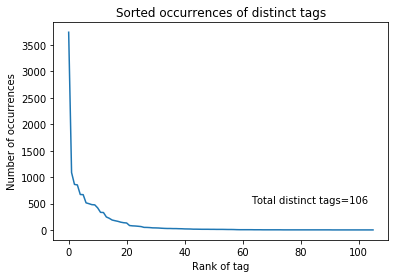

In [6]:
labels = metadata#['labels']
labels = labels[labels['hot'] == False] # exclude hot
labels = labels[labels['impaired'] == False] # exclude impaired
labels = labels[labels['failed'] == False] # exclude failed
labels.index = list(range(len(labels)))
print(len(labels))
labels = metadata['labels']

tags = [item for sublist in metadata['labels'] for item in sublist]

# use counter to compute frquencies
count = Counter(tags)

# separate labels and occurrences
tags, tags_occurrences = zip(*count.most_common())
# %% plot occurreces
num_occurrences_tags = len(tags_occurrences)
tag_indexes = np.arange(num_occurrences_tags)
plt.plot(tag_indexes, tags_occurrences)
plt.xlabel('Rank of tag')
plt.ylabel('Number of occurrences')
plt.text(63, 500, r'Total distinct tags=' + str(num_occurrences_tags))
plt.title('Sorted occurrences of distinct tags')
#plt.savefig('/home/frati/Grasping/code/CNN/labels.pdf',dpi=200)
plt.show()

# Taxonomy

![](taxonomy.png)

The cited taxonomy specifies a set of actions and 3 modifiers, but in our case we have some new labels and also the number of fingers used. Since we have not been given a complete taxonomy we are going to guess where to fit the extra labels and we are going to check that our guess is consistent with the dataset.

Action:

	"a"  -->  "approach"   [ s-side t-top u-unconstrained g-constrained (unguided/guided?)
	"f"  -->  "flip"       
	"c"  -->  "closing"    [ s t u g r-rotation]
	"e"  -->  "edge grasp" 
	"m"  -->  "movement"  (manipulation) (slide?) 
	"x"  -->  "fail"       
	"o"  -->  "other"      

Properties:

	"u"  -->  "unguided"   
	"g"  -->  "guided"     
	"r"  -->  "rotation"   
	"l"  -->  "translation"
	"d"  -->  "dual"       
	"n"  -->  "none"       
	"t"  -->  "top"        
	"s"  -->  "side"       
	"b"  -->  "beneath"    
	"p"  -->  "finger"     
	"q"  -->  "thumb"      
	"w"  -->  "wall"       
	"?"  -->  "? fingers"  
	"2"  -->  "2 fingers"  
	"3"  -->  "3 fingers"  
	"4"  -->  "4 fingers"  
	"5"  -->  "5 fingers"  

In [31]:
actions = ["a","f","c","e","m","x","o"]
modifiers = ["u","g","r","l","d","n","t","s","b","p","q","w","?","2","3","4","5"]

In [80]:
tags = [item for sublist in metadata['labels'] for item in sublist]

13526

Our guess:

In [34]:
mod_0 = ["u","g"]                     #-->  "unguided" "guided"     
     
mod_1 = ["t","s","b"]                 #-->  "top" "side" "beneath"     

mod_2 = ["?","2","3","4","5"]         #-->  number fingers  
   
mod_3 = ["p","q","w","l","d","r","n"] #-->  "finger" "thumb" "wall" "translation" "dual" "rotation" "none"
    

To check that our guess is consistent let's make sure that the intersection of the sets of labels containing modifiers from the same group is indeed empty. If the intersection is empty then the modifiers never appear together so we can assume that they are "alternatives".

In [35]:
distinc_tags = list(Counter(flat_tags).keys())

def intersection(a,b):
    set_a = set([x for x in distinc_tags if a in x])
    set_b = set([x for x in distinc_tags if b in x])
    return set_a.intersection(set_b)

for mod in [mod_0, mod_1, mod_2, mod_3]:
    for a,b in itertools.combinations(mod,2): # generate all combinations of 2 modifiers from a group
        assert intersection(a,b) == set()

Given this taxonomy we have 7 actions and 4 sets of modifiers with respectively 2,3,5,7 modifiers each. Each valid label in our dataset is then a combination of 1 action and some (or none) of these modifiers, for a total of $7*3*4*6*8 = 4032 $ possible labels.

In [36]:
possible_tags = list(itertools.product(actions))+\
list(itertools.product(actions,mod_0))+\
list(itertools.product(actions,mod_1))+\
list(itertools.product(actions,mod_2))+\
list(itertools.product(actions,mod_3))+\
list(itertools.product(actions,mod_0,mod_1))+\
list(itertools.product(actions,mod_0,mod_2))+\
list(itertools.product(actions,mod_0,mod_3))+\
list(itertools.product(actions,mod_1,mod_2))+\
list(itertools.product(actions,mod_1,mod_3))+\
list(itertools.product(actions,mod_2,mod_3))+\
list(itertools.product(actions,mod_0,mod_1,mod_2))+\
list(itertools.product(actions,mod_0,mod_1,mod_3))+\
list(itertools.product(actions,mod_0,mod_2,mod_3))+\
list(itertools.product(actions,mod_1,mod_2,mod_3))+\
list(itertools.product(actions,mod_0,mod_1,mod_2,mod_3))

possible_tags = list(map(set , possible_tags)) # use sets to abstract from the actual ordering
print(len(possible_tags))

4032


Let's now check that all the labels in our dataset appear in this list of possible labels

In [37]:
for tag in flat_tags:
    assert set(tag) in possible_tags

As an additional sanity check we count the actions in each tag and make sure that there is one and only one action per tag

In [38]:
for tag in flat_tags:
    actions_count = len([ 1 for letter in tag if letter in actions ])
    if actions_count != 1:
        print(tag)

# Dictionary

Now that we have a list of all the possible tags we can create a dictionary that we are going to use for our embedding

In [39]:
tags_to_ix = {}
for idx,tag in enumerate(possible_tags):
    tags_to_ix[''.join(sorted(tag))] = idx
    
tags_to_ix[''.join(sorted('START'))] = len(tags_to_ix) # add START
tags_to_ix[''.join(sorted('STOP'))] = len(tags_to_ix) # add STOP
tags_to_ix[''.join(sorted('UNK'))] = len(tags_to_ix) # add UNKNOWN

ix_to_tag = {val:key for key,val in tags_to_ix.items()}

with open('tags_to_ix.pkl','wb') as f:
    pickle.dump(tags_to_ix,f)

In [40]:
def convert_tag(tag):
    s_tag = ''.join(sorted(tag))
    return tags_to_ix[s_tag],s_tag

print(convert_tag('atu'))
print(convert_tag('uta'))
print(convert_tag('STOP'))
print(convert_tag('UNK'))

(126, 'atu')
(126, 'atu')
(4033, 'OPST')
(4034, 'KNU')


In [41]:
def revert_to_tag(num):
    return ix_to_tag[num]

print(revert_to_tag(126))
print(revert_to_tag(1260))
print(revert_to_tag(4032))

atu
psux
ARSTT


Let's pack these funtions into a class toghether with the dictionary so we can pickle it and use it where we need it.

In [42]:
class Dictionary():
    def __init__(self, tag_to_ix_path):
        with open(tag_to_ix_path,'rb') as f:
                self.tags_to_ix = pickle.load(f)
        self.ix_to_tag = {val:key for key,val in self.tags_to_ix.items()}
    
    def __len__(self):
        return len(self.tags_to_ix)
    
    def __call__(self,tag):
        s_tag = ''.join(sorted(tag))
        print(s_tag)
        if not s_tag in self.tags_to_ix:
            s_tag = 'KNU'
        return self.tags_to_ix[s_tag]
    
    def revert_to_tag(self,num):
        return self.ix_to_tag[num]

In [43]:
t = Dictionary(tag_to_ix_path='tags_to_ix.pkl')
print("Len: {}".format(len(t)))
to_convert = 'atu'
print("Convert {} -> {}".format(to_convert,t(to_convert)))
print("Revert 3114 -> {}".format(t.revert_to_tag(3114)))

Len: 4035
atu
Convert atu -> 126
Revert 3114 -> 4cgnt


In [44]:
'KNU' in t.tags_to_ix

True

# Unbalance analysis

In [7]:
folder='/home/frati/'

df = pd.read_pickle(folder +'/Grasping/Squared/metadata.pkl.compress', compression='gzip')

ix_to_obj = list(pd.read_pickle(folder+'/Grasping/Squared/index.pkl.compress', compression='gzip'))
obj_to_ix = {}
for idx,el in enumerate(list(ix_to_obj)):
    obj_to_ix[el] = idx

df = df[df['hot'] == False] # exclude hot
df = df[df['impaired'] == False] # exclude impaired
df = df[df['failed'] == False] # exclude failed
df.index = list(range(len(df)))

In [8]:
l = df[['object','labels']]

In [9]:
len(l)

1631

In [10]:
len_tags = [len(tag) for tag in l['labels']]
#Counter(len_tags)
print(np.mean(len_tags))
print(np.std(len_tags))

2.4236664622930717
0.7169005065772872


In [11]:
first_tags = [tags[0] for tags in l['labels']]

In [12]:
[(tag,occurr/len(first_tags)) for tag,occurr in Counter(first_tags).most_common()]

[('atu', 0.8522378908645003),
 ('abu', 0.05150214592274678),
 ('asu', 0.04598405885959534),
 ('atg', 0.0269773145309626),
 ('abg', 0.015328019619865114),
 ('asg', 0.00674432863274065),
 ('o', 0.001226241569589209)]

In [13]:
second_tags = [tags[1] for tags in l['labels']]
[(tag,occurr/len(second_tags)) for tag,occurr in Counter(second_tags).most_common(10)]

[('c2tgn', 0.19742489270386265),
 ('c2tgr', 0.15328019619865113),
 ('c3tgn', 0.13979153893316984),
 ('mtgl', 0.06805640711220111),
 ('o', 0.05027590435315757),
 ('mtgd', 0.039852851011649294),
 ('c3tun', 0.03923973022685469),
 ('c3tgr', 0.034334763948497854),
 ('c3bgn', 0.030656039239730228),
 ('c4tgn', 0.026364193746167996)]

In [61]:
d = {}
for name,group in l.groupby('object'):
    d[name] = list((group['labels']))

In [72]:
q = {}
for (key,val) in d.items():
    q[key] = Counter([len(el) for el in val]).most_common()

In [73]:
q

{'book': [(4, 36), (5, 33), (3, 32), (2, 14), (6, 7), (7, 2)],
 'bowl': [(2, 168), (3, 3)],
 'button': [(3, 100),
  (4, 13),
  (5, 7),
  (6, 3),
  (2, 2),
  (7, 1),
  (10, 1),
  (12, 1)],
 'cd': [(3, 89), (4, 8), (6, 4), (5, 3)],
 'chestnut': [(2, 157), (3, 4)],
 'cigarette': [(2, 119), (3, 16), (5, 6), (4, 1), (6, 1)],
 'coffee_mug': [(2, 116), (3, 39), (4, 10), (5, 5)],
 'comb': [(3, 74), (4, 12), (5, 8), (2, 6), (6, 3), (7, 2), (8, 1)],
 'credit_card': [(3, 88), (4, 10), (5, 7), (6, 2), (14, 1)],
 'french_chalk': [(3, 123), (2, 12), (4, 8), (5, 3), (6, 2)],
 'game_card': [(3, 99),
  (4, 10),
  (5, 9),
  (2, 3),
  (7, 2),
  (6, 1),
  (9, 1),
  (12, 1)],
 'glasses': [(2, 164), (3, 5)],
 'key': [(3, 66), (4, 10), (5, 3), (6, 3), (10, 1)],
 'marker': [(2, 155), (3, 8), (4, 1)],
 'match': [(2, 78), (3, 28), (4, 19), (5, 5), (6, 1), (8, 1)],
 'matchbox': [(2, 166), (3, 2), (4, 1)],
 'plate': [(2, 155), (3, 12), (4, 2), (7, 1)],
 'rubber_band': [(2, 153), (3, 3), (4, 1)],
 'salt_shaker': [

In [117]:
errors = 0
correct = 0
tot = 0
second_tag_candidates = ['c2tgn','c3tgn','c2tgr','c2tun','mtul','c3tun','o']
second_tag_weights = np.array([554,448,423,405,377,315,315])

second_tag_weights = second_tag_weights/second_tag_weights.sum()

for tag in tags:
    if(tag[0] == 'atu'):
        correct += 1
        
    #draw = np.random.choice(second_tag_candidates, 1, p=second_tag_weights)
    draw = 'c2tgn'
    if(len(tag) > 1 and tag[1] == draw):
        correct += 1
    
    if(len(tag) == 2):
        correct += 1
    
    tot += len(tag)

print(correct/tot)

0.5008132485583321
